In [90]:
%pip install torch

Note: you may need to restart the kernel to use updated packages.


In [91]:
# import pyogrio

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)

df = pd.read_csv('data.csv', on_bad_lines="warn", delimiter=";")
df.head()

,Melding ID,Meldingstidspunkt,Meldingsdato,Meldingsklokkeslett,Starttidspunkt,Startdato,Startklokkeslett,Startposisjon bredde,Startposisjon lengde,Hovedområde start (kode),Hovedområde start,Lokasjon start (kode),Havdybde start,Stopptidspunkt,Stoppdato,Stoppklokkeslett,Varighet,Fangstår,Stopposisjon bredde,Stopposisjon lengde,Hovedområde stopp (kode),Hovedområde stopp,Lokasjon stopp (kode),Havdybde stopp,Trekkavstand,Redskap FAO (kode),Redskap FAO,Redskap FDIR (kode),Redskap FDIR,Hovedart FAO (kode),Hovedart FAO,Hovedart - FDIR (kode),Art FAO (kode),Art FAO,Art - FDIR (kode),Art - FDIR,Art - gruppe (kode),Art - gruppe,Rundvekt,Lengdegruppe (kode),Lengdegruppe,Bruttotonnasje 1969,Bruttotonnasje annen,Bredde,Fartøylengde
0,1497177,01.01.2018,01.01.2018,00:00,31.12.2017,31.12.2017,00:00,"-60,35","-46,133",NaN,NaN,NaN,-2740,01.01.2018,01.01.2018,00:00,1440,2018,"-60,4","-46,15",NaN,NaN,NaN,-805,5649.0,OTM,"Flytetrål, otter",53.0,Flytetrål,KRI,Antarktisk krill,2513.0,KRI,Antarktisk krill,2513.0,Antarktisk krill,506.0,Antarktisk krill,706714.0,5.0,28 m og over,9432.0,NaN,"19,87","133,88"
1,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,2017,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,OTB,"Bunntrål, otter",51.0,Bunntrål,HAD,Hyse,1027.0,HAD,Hyse,1027.0,Hyse,202.0,Hyse,9594.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
2,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,2017,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,OTB,"Bunntrål, otter",51.0,Bunntrål,HAD,Hyse,1027.0,COD,Torsk,1022.0,Torsk,201.0,Torsk,8510.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
3,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,2017,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,OTB,"Bunntrål, otter",51.0,Bunntrål,HAD,Hyse,1027.0,GHL,Blåkveite,2313.0,Blåkveite,301.0,Blåkveite,196.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
4,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,2017,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,OTB,"Bunntrål, otter",51.0,Bunntrål,HAD,Hyse,1027.0,POK,Sei,1032.0,Sei,203.0,Sei,134.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"


As our hypothetical use case, we imagine a government agency that is interested to predict how much endangered fish a given catch operation has caught.

We used "https://artsdatabanken.no/lister/rodlisteforarter/2021?Name=&SortBy=ScientificName&Meta=Visited&Meta=scroll_658&IsCheck=Area&Area=N&IsCheck=Category&Category=CR&Category=EN&IsCheck=SpeciesGroups&SpeciesGroups=Fisker&IsCheck=Insekter" to find endangered species of fish. 

Three of these are included in the dataset:

1. Vanlig Uer
2. Blålange
3. Ål

Our strategy will be to trim unnecessary columns, turn species into boolean columns and have machine learning models predict the amount (weight) caught of the given species for each catch operation.

<!-- A lot of the data in the columns needs to be converted into boolean and number values, and some needs to be omitted due to inaccuracies.  -->



In [92]:
# df.info()
uer_df = df[df['Art FAO'] == "Uer (vanlig)"] 
blålange_df = df[df['Art FAO'] == "Blålange"] 
ål_df = df[df['Art FAO'] == "Ål"] 
print("Number of catches containing Uer: ", len(uer_df))
print("Number of catches containing Blålange: ", len(blålange_df))
print("Number of catches containing Ål: ", len(ål_df))


Number of catches containing Uer:  14153
Number of catches containing Blålange:  991
Number of catches containing Ål:  2


There are only two catch operations containing Ål, we need more data in order to predict for this species.
For Blålange and Uer we can move on. It's difficult to say beforehand wether or not 991 positive datapoints will be enough to accurately predict the Rundvekt of Blålange, but it's within the realm of possibilities.
 
**Data Processing**

To begin trimming down the amount of data, we can safely drop columns where the data is already present in other columns

In [93]:
df = df.drop(labels=["Meldingsdato","Meldingsklokkeslett","Startdato","Startklokkeslett", "Stoppdato", "Stoppklokkeslett", "Lengdegruppe (kode)", "Lengdegruppe"], axis=1)
df = df.drop(labels=["Hovedart FAO (kode)","Hovedart FAO","Hovedart - FDIR (kode)","Art - gruppe","Art - gruppe (kode)", "Art - FDIR (kode)", "Art - FDIR", "Redskap FDIR (kode)", "Redskap FDIR"], axis=1)



We notice that Start/Stop times are inconsistent. We therefore filter out Start/Stop times which do not contain ':'. This way we can trust the 'Varighet' column more.

Furthermore, 'Fartøylengde', 'Bredde', 'Startposisjon bredde', 'Startposisjon lengde', 'Stopposisjon bredde', 'Stopposisjon lengde' is written with ',' and not '.'. We change ',' to '.' and cast to float datatype.

In [94]:
df = df[df["Starttidspunkt"].str.contains(":")]
df = df[df["Stopptidspunkt"].str.contains(":")]

castable_columns = ["Fartøylengde", "Bredde", "Startposisjon bredde", "Startposisjon lengde", "Stopposisjon bredde", "Stopposisjon lengde"]

for column in castable_columns:
    df[column] = df[column].str.replace(",", ".").astype("float")



Next we need to convert the categorical column values we _do_ want to use into machine-readable data. In this case we use the built-in get_dummies function to create boolean columns.

In [95]:
species_columns = pd.get_dummies(df["Art FAO"], dtype="float") 
species_columns_multiplied = species_columns.multiply(df["Rundvekt"], axis="index") # Keep weight of fish

endangered_species_1 = species_columns_multiplied["Uer (vanlig)"]
endangered_species_2 = species_columns_multiplied["Blålange"]

# Add endangered species and drop original columns.
df = pd.concat([df,endangered_species_1 ], axis=1)
df = pd.concat([df,endangered_species_2 ], axis=1)
df = df.drop(["Art FAO", "Art FAO (kode)" ], axis=1)




tool_columns = pd.get_dummies(df["Redskap FAO"])
df = pd.concat([df,tool_columns], axis=1) 

# Checking count of the diffrent tools used before grouping
# boolean_columns = df.select_dtypes(include=['bool']).columns
# counts = {col: df[col].value_counts() for col in boolean_columns}
# for col, count in counts.items():
#     print(f"Value counts for {col}:\n{count}\n")

df = df.drop(["Redskap FAO", "Redskap FAO (kode)"], axis=1)


In order to reduce the amount of parameters, we group the fishing tools into sensible categories.

In [96]:
# TODO Compact this

columns_to_group = ['Bunntrål (uspes)', 'Bunntrål, otter', 'Bunntrål, par','Bunntrål, reke','Skrape, mekanisert', 'Otter dobbeltrål', 'Otter dobbeltrål']

df['DivBunntrål'] = df[columns_to_group].any(axis=1)
df = df.drop(columns=columns_to_group, axis=1)

columns_to_group = ['Snurrevad, skotsk', 'Snurrevad, dansk', 'Snurrevad']

df['DivSnurrevad'] = df[columns_to_group].any(axis=1)
df = df.drop(columns=columns_to_group, axis=1)

columns_to_group = ['Snurpenot/ringnot, to fartøy', 'Snurpenot/ringnot, et fartøy', 'Snurpenot/ringnot', 'Boat /vessel seines -Pair seines']

df['DivSnurpenot/ringnot'] = df[columns_to_group].any(axis=1)
df = df.drop(columns=columns_to_group, axis=1)

columns_to_group = ['Flytetrål, otter', 'Flytetrål, par', 'Flytetrål, reke','Flytetrål, uspesifisert']

df['DivFlytetrål'] = df[columns_to_group].any(axis=1)
df = df.drop(columns=columns_to_group, axis=1)

columns_to_group = ['Udefinert garn', 'Settegarn', 'Gillnets and entangling nets (unspec)*','Encircling gillnets*']

df['DivGarn'] = df[columns_to_group].any(axis=1)
df = df.drop(columns=columns_to_group, axis=1)

columns_to_group = ['Andre liner', 'Setteline', 'Dorg/harp/snik','Juksa/pilk, manuell']

df['DivLine'] = df[columns_to_group].any(axis=1)
df = df.drop(columns=columns_to_group, axis=1)

columns_to_group = ['Harpun,div.', 'Partrål, uspesifisert', 'Teiner','Udefinert trål','Annen trål (udefinert)']

df['Annet'] = df[columns_to_group].any(axis=1)
df = df.drop(columns=columns_to_group, axis=1)

# checking count of tools after grouping 
# boolean_columns = df.select_dtypes(include=['bool']).columns
# counts = {col: df[col].value_counts() for col in boolean_columns}
# for col, count in counts.items():
#     print(f"Value counts for {col}:\n{count}\n")


df.head()

,Melding ID,Meldingstidspunkt,Starttidspunkt,Startposisjon bredde,Startposisjon lengde,Hovedområde start (kode),Hovedområde start,Lokasjon start (kode),Havdybde start,Stopptidspunkt,Varighet,Fangstår,Stopposisjon bredde,Stopposisjon lengde,Hovedområde stopp (kode),Hovedområde stopp,Lokasjon stopp (kode),Havdybde stopp,Trekkavstand,Rundvekt,Bruttotonnasje 1969,Bruttotonnasje annen,Bredde,Fartøylengde,Uer (vanlig),Blålange,DivBunntrål,DivSnurrevad,DivSnurpenot/ringnot,DivFlytetrål,DivGarn,DivLine,Annet
1,1497178,01.01.2018,30.12.2017 23:21,74.885,16.048,20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,295,2017,74.914,15.969,20.0,Bjørnøya,7.0,-334,3970.0,9594.0,1476.0,NaN,12.6,56.8,0.0,0.0,True,False,False,False,False,False,False
2,1497178,01.01.2018,30.12.2017 23:21,74.885,16.048,20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,295,2017,74.914,15.969,20.0,Bjørnøya,7.0,-334,3970.0,8510.0,1476.0,NaN,12.6,56.8,0.0,0.0,True,False,False,False,False,False,False
3,1497178,01.01.2018,30.12.2017 23:21,74.885,16.048,20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,295,2017,74.914,15.969,20.0,Bjørnøya,7.0,-334,3970.0,196.0,1476.0,NaN,12.6,56.8,0.0,0.0,True,False,False,False,False,False,False
4,1497178,01.01.2018,30.12.2017 23:21,74.885,16.048,20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,295,2017,74.914,15.969,20.0,Bjørnøya,7.0,-334,3970.0,134.0,1476.0,NaN,12.6,56.8,0.0,0.0,True,False,False,False,False,False,False
5,1497178,01.01.2018,31.12.2017 05:48,74.910,15.868,20.0,Bjørnøya,7.0,-403,31.12.2017 10:15,267,2017,74.901,16.248,20.0,Bjørnøya,7.0,-277,11096.0,9118.0,1476.0,NaN,12.6,56.8,0.0,0.0,True,False,False,False,False,False,False


When grouping the different catch operations, it's important to be precise when telling pandas how to process the different rows.

The data in most columns is identical, for those we can use 'mean' or 'first'.

For some, like the endangered species columns, only one row will contain our fish, rest will be zero. We must therefore use 'sum' to capture the weight of the endangereed species.

For 'Rundvekt' we should also use 'sum'. 

In [97]:
species_dict = {
    "Uer (vanlig)": "sum",
    "Blålange": "sum",
}
tool_dict= dict.fromkeys(['Annet','DivBunntrål','DivSnurrevad','DivSnurpenot/ringnot','DivFlytetrål','DivGarn','DivLine'], "first")

catch_dict = {
        "Varighet": "mean",
        "Fangstår": "mean",
        "Trekkavstand": "mean",
        "Bredde": "mean",
        "Fartøylengde" : "mean",
        "Bruttotonnasje": "mean",
        "Rundvekt": "sum",
        "Havdybde start": "mean",
        "Havdybde stopp": "mean",
        "Startposisjon lengde": "mean",
        "Startposisjon bredde": "mean",
        "Stopposisjon lengde": "mean",
        "Stopposisjon bredde": "mean",

    }
master_dict = {**catch_dict, **tool_dict, **species_dict}

It's natural to think that the size of the vessel is important for predicting how much fish is caught.

In order to use 'Bruttotonnasje' one option is to pick one of the columns, delete the other one and drop all n/a values.

We decided on a slightly different approach in order to preserve more rows.
We base the 'Bruttotonnasje' value on the standard 'Bruttotonnasje 1969' and instead of dropping rows right away, we check if the row contains a value in 'Bruttotonnasje annen', and use that.
Rows with missing values in both columns are dropped.


In [98]:

df = df.dropna(subset=["Bruttotonnasje 1969", "Bruttotonnasje annen"], how='all')
df["Bruttotonnasje"] = df["Bruttotonnasje 1969"].fillna(df["Bruttotonnasje annen"])
df = df.drop(["Bruttotonnasje 1969", "Bruttotonnasje annen"], axis=1)


It should be noted that 'Bruttotonnasje' is pretty well explained by 'Fartøylengde', although in a non-linear fashion. In light of this, we could probably omit either 'Bruttotonnasje' or the boat dimensions.
See graph.

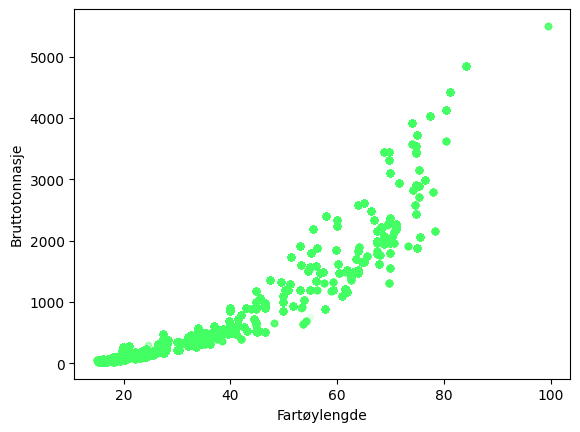

In [99]:

df.plot(kind = 'scatter', x = 'Fartøylengde', y = 'Bruttotonnasje', c="#43ff640d")
plt.show()

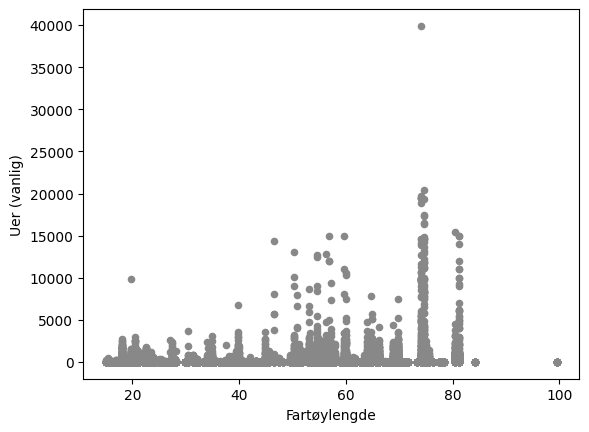

In [100]:

df.plot(kind = 'scatter', x = 'Fartøylengde', y = 'Uer (vanlig)', c="#888")
plt.show()

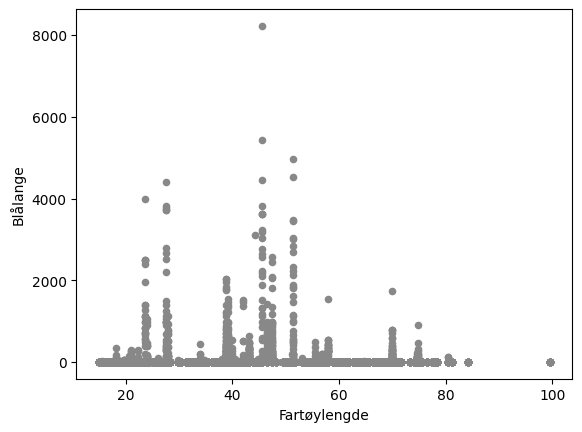

In [101]:

df.plot(kind = 'scatter', x = 'Fartøylengde', y = 'Blålange', c="#888")
plt.show()

Some catch operations are claimed to have taken place in very unusual and sometimes impossible locations.
Furthermore, some weights of the endangered species are incredibly high. We suspect this will distort the model, so we remove those.

In [102]:
df = df.drop(df[df["Startposisjon lengde"] < -50].index)
df = df.drop(df[df["Startposisjon lengde"] > 60].index)
df = df.drop(df[df["Startposisjon bredde"] < 40].index)
df = df.drop(df[df["Uer (vanlig)"] > 25000].index) # Outlier
df = df.drop(df[df["Blålange"] > 8000].index) # Outlier


Geographic Visualization of where Uer is caught surrounding Norway. 

/var/folders/vc/3x4nt6w91vb8xw0gvcj8vcj40000gn/T/ipykernel_43861/3351875174.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  gpd.datasets.get_path("naturalearth_lowres"))


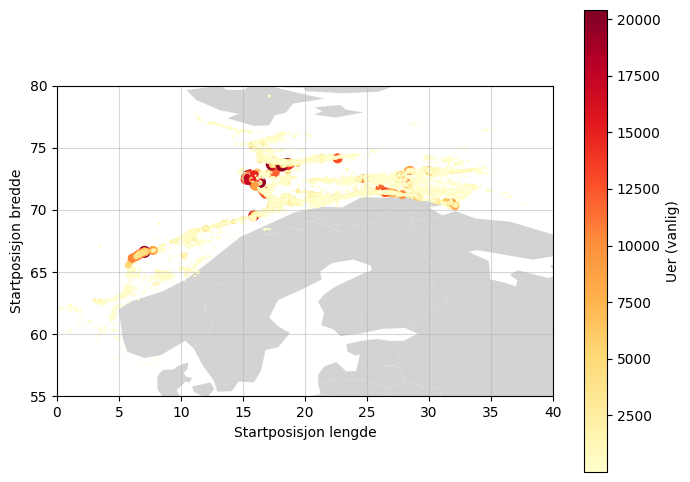

In [103]:
# initialize an axis
fig, ax = plt.subplots(figsize=(8,6))
# plot map on axis
countries = gpd.read_file(  
     gpd.datasets.get_path("naturalearth_lowres"))
countries.plot(color="lightgrey",
                                                 ax=ax)
df_positive_uer = df.drop(df[df["Uer (vanlig)"] == 0].index)

# plot points
df_positive_uer.plot(x="Startposisjon lengde", y="Startposisjon bredde", kind="scatter", 
        c="Uer (vanlig)", colormap="YlOrRd", s=df_positive_uer["Uer (vanlig)"].multiply(0.003),
        ax=ax)
# add grid
ax.grid( alpha=0.5)
ax.set_xlim(0, 40)
ax.set_ylim(55, 80)
plt.show()


Geographic Visualization of where Blålange is caught surrounding Norway. 

/var/folders/vc/3x4nt6w91vb8xw0gvcj8vcj40000gn/T/ipykernel_43861/4277941055.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  gpd.datasets.get_path("naturalearth_lowres"))


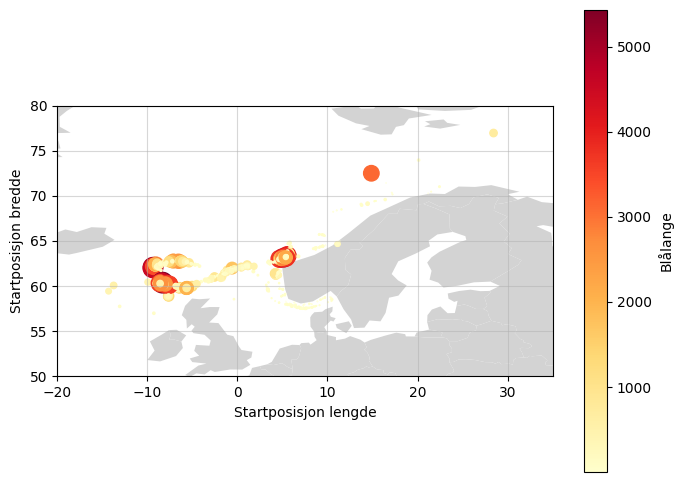

In [104]:
# initialize an axis
fig, ax = plt.subplots(figsize=(8,6))
# plot map on axis
countries = gpd.read_file(  
     gpd.datasets.get_path("naturalearth_lowres"))
countries.plot(color="lightgrey",
                                                 ax=ax)

df_positive_lange = df.drop(df[df["Blålange"] == 0].index)
# plot points
df_positive_lange.plot(x="Startposisjon lengde", y="Startposisjon bredde", kind="scatter", 
        c="Blålange", colormap="YlOrRd", s=df_positive_lange["Blålange"].multiply(0.04),
        ax=ax)
# add grid
ax.grid( alpha=0.5)
ax.set_xlim(-20, 35)
ax.set_ylim(50, 80)
plt.show()

We are now ready to collapse the entries into catch operations.

In [105]:

df_processed = df.groupby(by=["Melding ID", "Starttidspunkt", "Stopptidspunkt"]).agg(master_dict).reset_index()

df_processed =  df_processed.drop(columns=['Starttidspunkt','Stopptidspunkt'])
df_processed.shape
df_processed

,Melding ID,Varighet,Fangstår,Trekkavstand,Bredde,Fartøylengde,Bruttotonnasje,Rundvekt,Havdybde start,Havdybde stopp,Startposisjon lengde,Startposisjon bredde,Stopposisjon lengde,Stopposisjon bredde,Annet,DivBunntrål,DivSnurrevad,DivSnurpenot/ringnot,DivFlytetrål,DivGarn,DivLine,Uer (vanlig),Blålange
0,1497178,295.0,2017.0,3970.0,12.60,56.80,1476.0,18434.0,-335.0,-334.0,16.048,74.885,15.969,74.914,False,True,False,False,False,False,False,0.0,0.0
1,1497178,267.0,2017.0,11096.0,12.60,56.80,1476.0,16062.0,-403.0,-277.0,15.868,74.910,16.248,74.901,False,True,False,False,False,False,False,0.0,0.0
2,1497178,315.0,2017.0,10215.0,12.60,56.80,1476.0,17878.0,-346.0,-496.0,16.056,74.883,15.742,74.924,False,True,False,False,False,False,False,37.0,0.0
3,1497178,243.0,2017.0,3214.0,12.60,56.80,1476.0,13780.0,-443.0,-358.0,15.785,74.931,15.894,74.926,False,True,False,False,False,False,False,0.0,0.0
4,1497229,63.0,2018.0,1269.0,5.06,19.10,51.0,4.0,-71.0,-56.0,12.972,67.828,12.942,67.827,False,False,True,False,False,False,False,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97718,1800286,232.0,2018.0,2400.0,10.50,39.79,691.0,9023.0,-191.0,-178.0,22.141,70.862,22.188,70.877,False,True,False,False,False,False,False,0.0,0.0
97719,1800291,301.0,2018.0,13284.0,12.60,57.30,1483.0,11105.0,-193.0,-341.0,14.295,76.509,14.679,76.431,False,True,False,False,False,False,False,51.0,0.0
97720,1800291,345.0,2018.0,44035.0,12.60,57.30,1483.0,10017.0,-244.0,-299.0,14.932,76.385,13.642,76.640,False,True,False,False,False,False,False,51.0,0.0
97721,1800291,328.0,2018.0,41216.0,12.60,57.30,1483.0,10427.0,-280.0,-289.0,13.800,76.606,12.820,76.899,False,True,False,False,False,False,False,102.0,0.0


**Supervised Learning**

TODO: Preprocessing of data with reasoning 

TODO: Build 3 supervised learning models, one of which needs to be a deep learning model

KNN (regressor), nevralt nett (deep learning, pytorch, keras, tensorflow), spicy learning model 

**Unsupervised Learning (Clustering Model)**

TODO: Preprocessing of data with reasoning

TODO: Build Clustering Model 

In [106]:
df_knn = df_processed

In [107]:
"""df_knn.drop(columns=['Meldingstidspunkt', 'Starttidspunkt', 'Hovedområde start', 'Stopptidspunkt', 'Hovedområde stopp'],
            inplace=True)"""

"df_knn.drop(columns=['Meldingstidspunkt', 'Starttidspunkt', 'Hovedområde start', 'Stopptidspunkt', 'Hovedområde stopp'],\n            inplace=True)"

In [108]:
# removing nan rows
df_knn = df_knn.dropna()

In [109]:
X = df_knn.drop('Uer (vanlig)', axis=1)
y = df_knn['Uer (vanlig)']

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [111]:

knn_regressor = KNeighborsRegressor(n_neighbors=7)
knn_regressor.fit(X_train_scaled, y_train)
y_pred = knn_regressor.predict(X_test_scaled)

In [112]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R^2 Score: {r2}")

MSE: 104187.56232068101
RMSE: 322.7809819687043
MAE: 45.50150347724802
R^2 Score: 0.6096598522070956


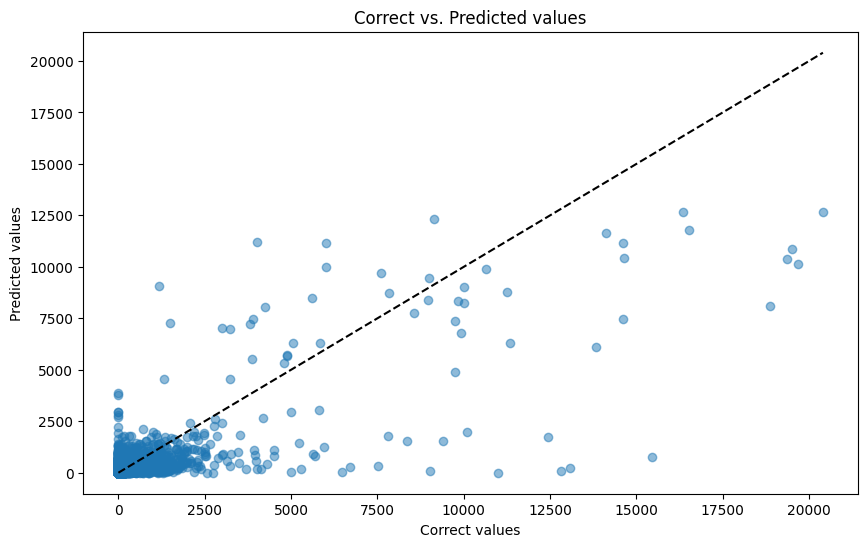

In [113]:
# Visualizing the predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Correct values')
plt.ylabel('Predicted values')
plt.title('Correct vs. Predicted values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--')
plt.show()

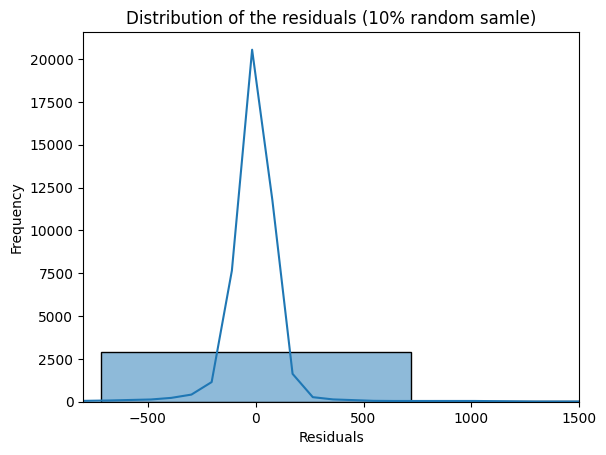

In [114]:


residuals = y_test - y_pred

residuals = residuals[~np.isnan(residuals)]
residuals = residuals[np.isfinite(residuals)]

# Distribution of 10% random sample of the data resudials
test_size = int(len(residuals) * 0.1)
random_sample = np.random.choice(residuals, size=test_size, replace=False)

plt.xlim(-800, 1500)
sns.histplot(random_sample, kde=True)
plt.title('Distribution of the residuals (10% random samle)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


**Results and comments**

TODO: "write a summary of your results, and discuss consequences of such results."
